# Trying to resemble Bouttes more closely.

I don't think the current behaviour resembles Bouttes enough. We have been using parameters that are supposedly the same, so it should look like Bouttes. I don't know why it doesn't. We have a much larger temperature change than Bouttes does. That is not something we have altered..
-Have we used epsilon =1 properly?  => YES

What if we say we have reproduced Bouttes.. (But I'm not convinced). Then we have 2 tasks:

-Figure out parameter sensitivities
-See if a bigger kappa will give us more satifying differences in terms of asymmetry.

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

In [43]:
d_u = 100       # m
d_l = 2000      # m

alpha = 0.81    # W m^-2 K^-2
c = 4.218e6     # J m^-3 K^-1
k = 1e-4        # m^2 s^-1  

gamma = c * k / (0.5 * (d_l + d_k))
print(gamma)

C_0 = c * d_l / (60*60*24*365)
C = c * d_u / (60*60*24*365)

print(C, C_0)


0.2109
13.375190258751903 267.50380517503805


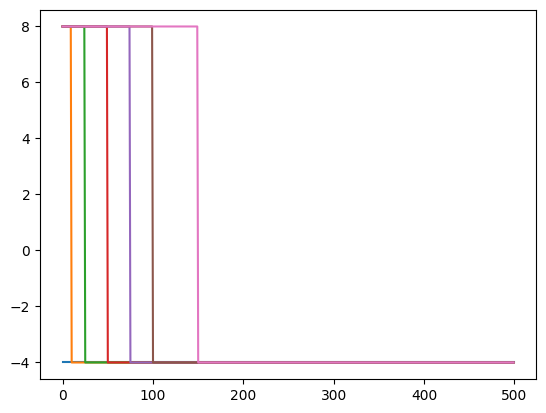

In [49]:
ts = np.array([0,10 ,25,50,75,100,150])

f_scenarios = {}

for t in ts:
    force = (np.ones(500) * -4)
    force[:t] *= -2
    f_scenarios[t] = force

for f in f_scenarios:
    plt.plot(f_scenarios[f])


run_names = []


for t in ts:
    run_names.append(f"t = %s, k = %s" %(t,0))
    run_names.append(f"t = %s, k = %s" %(t,0.1))

In [50]:
#Running with Geoffroy parameters but Bouttes Heat capacity. dt=3 for speed. epsilon=1

runs = {}
kappas = [0, 0.1]
#ts = [0]

for kappa in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(kappa,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=1.18,
                t2x=None,
                eff=1, #No epsilon
                cmix=C,
                cdeep=C_0,
                gamma_2l=0.67,
                kappa=kappa, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=3
            )
        
            out = scm.run()
    
        runs[f"t = %s, k = %s" %(t,kappa)] = out

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [00:17<00:00, 58.56it/s]


currently on kappa 0, t:10 


100%|██████████| 1000/1000 [00:14<00:00, 70.15it/s]


currently on kappa 0, t:25 


100%|██████████| 1000/1000 [00:13<00:00, 75.47it/s]


currently on kappa 0, t:50 


100%|██████████| 1000/1000 [00:18<00:00, 55.50it/s]


currently on kappa 0, t:75 


100%|██████████| 1000/1000 [00:22<00:00, 45.34it/s]


currently on kappa 0, t:100 


100%|██████████| 1000/1000 [00:20<00:00, 49.42it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:20<00:00, 48.67it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:23<00:00, 41.96it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:19<00:00, 50.63it/s]


currently on kappa 0.1, t:25 


100%|██████████| 1000/1000 [00:19<00:00, 50.89it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:20<00:00, 49.55it/s]


currently on kappa 0.1, t:75 


100%|██████████| 1000/1000 [00:20<00:00, 49.24it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:18<00:00, 54.49it/s]


0
10
25
50
75
100
150
0.4694272764730122 50.325504738360124
0.7470539761021843 46.52327976926259


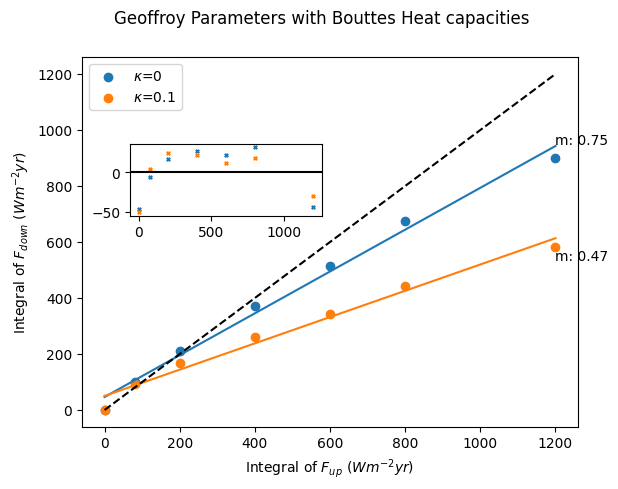

In [56]:
import matplotlib.pyplot as plt
#import math
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time
#ts = [10,25,50, 75, 100]


#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

t_0k = []
t_01k = []
return_times = {}

ts_instance = []
for scen in runs:
    run = runs[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #ts_instance.append(t)
    #print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i][0]
    if k == "0":
        print(t)
        fint_up.append(8 * t)
        t_0k.append(run.time[i][0])
        fint_down0.append(4 * (run.time[i][0]-t))
    else:
        t_01k.append(run.time[i][0])
        fint_down01.append(4 * (run.time[i][0]-t))

#print(t_0k, t_01k)
#print(return_times)
#print(ts_instance)


#fint_up = np.sort(fint_up)

#for ind, t in enumerate(ts_instance):
  #  fint_up.append( 8 * t)
  #  fint_down0.append(4 * (t_0k[ind]-t))
   # fint_down01.append(4 * (t_01k[ind]-t))


#Fitting using lstsqs

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
print(m1,c1)

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
print(m0,c0)

xs = np.array(fint_up)
residuals0 = (fint_down0 - ( m0 * xs + c0) )
residuals01 = (fint_down01 - ( m1 * xs + c1 ))

fig, axs = plt.subplots()
fig.suptitle("Geoffroy Parameters with Bouttes Heat capacities")

axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
axs.plot(xs, m0 * xs + c0)
axs.plot(xs, m1 * xs + c1)
axs.plot(np.sort(xs), np.sort(xs), "k", linestyle= "dashed")
axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1],fint_down0[-1]+50))
axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1],fint_down01[-1]-50 ))
axs.legend()


l, b, h, w = .2, .55, .15, .3
ax2 = fig.add_axes([l, b, w, h])
ax2.scatter(xs, residuals0, marker="x", s = 6)
ax2.scatter(xs, residuals01, marker="x", s = 6)
ax2.axhline(0, color="k")

796.0


Text(0.5, 1.0, 'Geoffroy Parameters with Bouttes Heat capacities')

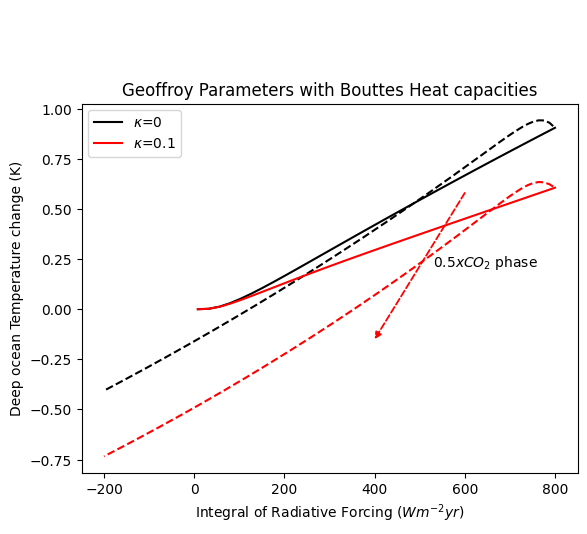

In [57]:
for name in runs:
    #print(name)
    i = name.index("t")
    j = name.index(",")
    t = int(name[i+4:j])
    if t != 100:
        continue 
    l = name.index("k")
    k = name[l+4:]
    #print(k)
    if k == "0":
        color = "black"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0")
        plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    if k == "0.1":
        color = "red"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0.1")
        print(f_up[-1] + f_down[0])
        plt.plot(f_down[:250] + f_up[-1], run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
    plt.ylabel("Deep ocean Temperature change (K)")
    #plt.xlim(-500,3000)
    plt.legend()

arrowStart=np.array([400,-0.15])
arrowStop=np.array([600,0.58])
arrowColor="red"
plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+30,((arrowStop+arrowStart)/2)[1]) )
plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

arrowStart2=np.array([620,1.5])
arrowStop2=np.array([400,1])
arrowColor2="red"
plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))
plt.title("Geoffroy Parameters with Bouttes Heat capacities")

Larger heat capacity ratios mask the effects of temp. dependent gammas. Let's try with a much smaller ratio..

In [59]:
print(C,C_0)

13.375190258751903 267.50380517503805


In [60]:
#Running with Geoffroy parameters but heat capacity ratio of C_0/C = 5

runs_5ratio = {}
kappas = [0, 0.1]
#ts = [0]

for kappa in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(kappa,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=1.18,
                t2x=None,
                eff=1, #No epsilon
                cmix=C_0/5,
                cdeep=C_0,
                gamma_2l=0.67,
                kappa=kappa, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=3
            )
        
            out = scm.run()
    
        runs_5ratio[f"t = %s, k = %s" %(t,kappa)] = out

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [00:21<00:00, 45.66it/s]


currently on kappa 0, t:10 


100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s]


currently on kappa 0, t:25 


100%|██████████| 1000/1000 [00:20<00:00, 47.92it/s]


currently on kappa 0, t:50 


100%|██████████| 1000/1000 [00:21<00:00, 45.79it/s]


currently on kappa 0, t:75 


100%|██████████| 1000/1000 [00:18<00:00, 53.69it/s]


currently on kappa 0, t:100 


100%|██████████| 1000/1000 [00:17<00:00, 56.20it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:18<00:00, 55.32it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:18<00:00, 52.85it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:18<00:00, 54.18it/s]


currently on kappa 0.1, t:25 


100%|██████████| 1000/1000 [00:18<00:00, 53.63it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:18<00:00, 53.19it/s]


currently on kappa 0.1, t:75 


100%|██████████| 1000/1000 [00:20<00:00, 49.32it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:19<00:00, 52.01it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:19<00:00, 52.46it/s]


0
10
25
50
75
100
150
0.6084260403790692 94.90894107952217
0.8137000412031319 77.58055212196128


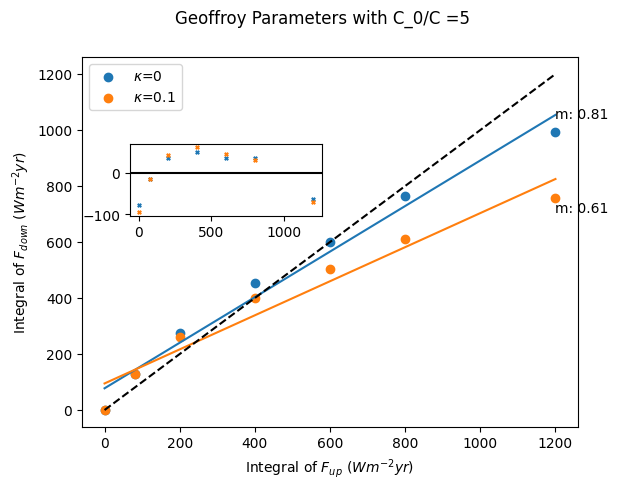

In [61]:

#import math
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time
#ts = [10,25,50, 75, 100]


#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

t_0k = []
t_01k = []
return_times = {}

ts_instance = []
for scen in runs_5ratio:
    run = runs_5ratio[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #ts_instance.append(t)
    #print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i][0]
    if k == "0":
        print(t)
        fint_up.append(8 * t)
        t_0k.append(run.time[i][0])
        fint_down0.append(4 * (run.time[i][0]-t))
    else:
        t_01k.append(run.time[i][0])
        fint_down01.append(4 * (run.time[i][0]-t))

#print(t_0k, t_01k)
#print(return_times)
#print(ts_instance)


#fint_up = np.sort(fint_up)

#for ind, t in enumerate(ts_instance):
  #  fint_up.append( 8 * t)
  #  fint_down0.append(4 * (t_0k[ind]-t))
   # fint_down01.append(4 * (t_01k[ind]-t))


#Fitting using lstsqs

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
print(m1,c1)

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
print(m0,c0)

xs = np.array(fint_up)
residuals0 = (fint_down0 - ( m0 * xs + c0) )
residuals01 = (fint_down01 - ( m1 * xs + c1 ))

fig, axs = plt.subplots()
fig.suptitle("Geoffroy Parameters with C_0/C =5")

axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
axs.plot(xs, m0 * xs + c0)
axs.plot(xs, m1 * xs + c1)
axs.plot(np.sort(xs), np.sort(xs), "k", linestyle= "dashed")
axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1],fint_down0[-1]+50))
axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1],fint_down01[-1]-50 ))
axs.legend()


l, b, h, w = .2, .55, .15, .3
ax2 = fig.add_axes([l, b, w, h])
ax2.scatter(xs, residuals0, marker="x", s = 6)
ax2.scatter(xs, residuals01, marker="x", s = 6)
ax2.axhline(0, color="k")

796.0


Text(0.5, 1.0, 'Geoffroy Parameters with C/C_0 =5')

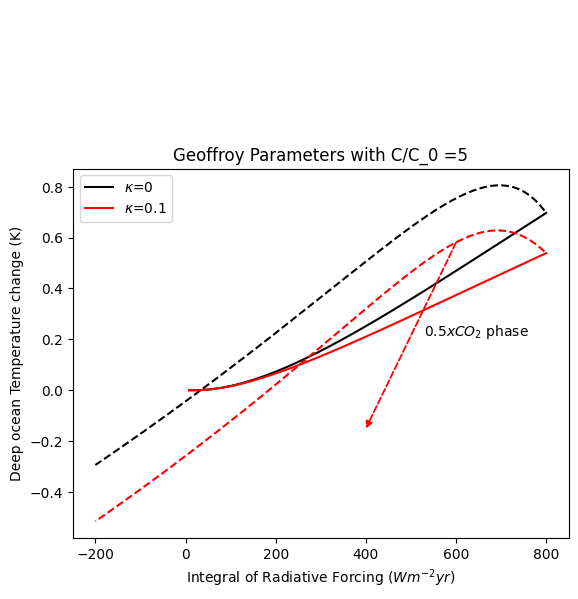

In [62]:
for name in runs_5ratio:
    #print(name)
    i = name.index("t")
    j = name.index(",")
    t = int(name[i+4:j])
    if t != 100:
        continue 
    l = name.index("k")
    k = name[l+4:]
    #print(k)
    if k == "0":
        color = "black"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs_5ratio[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0")
        plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    if k == "0.1":
        color = "red"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs_5ratio[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0.1")
        print(f_up[-1] + f_down[0])
        plt.plot(f_down[:250] + f_up[-1], run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
    plt.ylabel("Deep ocean Temperature change (K)")
    #plt.xlim(-500,3000)
    plt.legend()

arrowStart=np.array([400,-0.15])
arrowStop=np.array([600,0.58])
arrowColor="red"
plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+30,((arrowStop+arrowStart)/2)[1]) )
plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

arrowStart2=np.array([620,1.5])
arrowStop2=np.array([400,1])
arrowColor2="red"
plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))
plt.title("Geoffroy Parameters with C/C_0 =5")